# 누가 이탈할까??? 신용카드 고객 이탈 예측 프로젝트

- 작성자: 방준일  
- 날짜: 2025년 11월  
- 사용 데이터: Credit Card Customers (10,127명)

## 프로젝트 목표
- 신용카드 고객 중 이탈(Churn) 가능성이 높은 고객을 조기에 식별한다.
- 모델이 예측한 이탈 확률과 위험 등급(High/Medium/Low)을 기반으로 리텐션 액션을 설계한다.


## 분석 흐름

1. 데이터 로드 및 기본 정보 확인  
2. EDA: 변수 분포, 이탈률 탐색, 고위험 패턴 파악  
3. 전처리 파이프라인 설계 (수치/범주형 처리)  
4. 여러 분류 모델 성능 비교 및 SMOTE 도입  
5. SMOTE 기반 XGBoost(XGB_SMOTE) 하이퍼파라미터 튜닝(2회)  
6. 최종 모델(XGB_SMOTE) 선택 및 성능 평가  
7. 피처 중요도 해석  
8. 고객별 이탈 확률(churn_proba), 위험 등급(Risk_Pred) 산출  
9. 세그먼트별 리텐션 액션 제안 및 프로젝트 회고


In [ ]:
# 라이브러리 임포트

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_validate
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
!pip install koreanize-matplotlib
import koreanize_matplotlib



In [ ]:
df = pd.read_csv('/content/BankChurners_.csv')

df.columns


Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [ ]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [ ]:
# 타깃 변수 생성
df['Churn'] = df['Attrition_Flag'].map({
    'Existing Customer': 0,
    'Attrited Customer': 1
})

# 개수 / 비율
print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize=True))


Churn
0    8500
1    1627
Name: count, dtype: int64
Churn
0    0.83934
1    0.16066
Name: proportion, dtype: float64


이탈고객 : 1
유지고객 : 0

유지 고객 약 84%
이탈 고객 약 16%

대략 5:1 수준(80:20보다 더 심한 비율)의 한쪽 쏠림이 있는 이진 분류 데이터

일반적으로 이진 분류에서 한 클래스가 전체의 70~80% 이상을 차지하면 “불균형 데이터셋”으로 다룬다

특히 churn처럼 관심 있는 쪽이 소수 클래스인 문제에서, 이런 80:20, 85:15 수준의 비율은 모델이 다수 클래스(비이탈)만 맞춰도 Accuracy가 높게 나와 소수 클래스(이탈) Recall, F1이 망가지는 전형적인 클래스 불균형 상황으로 본다

따라서 타깃 분포(Churn=1 약 16%)를 먼저 확인하고

클래스 불균형 문제 존재 → SMOTE로 소수 클래스 보강 + F1/Recall을 핵심 지표로 사용하는 것이 좋겠다

In [ ]:
#성별, 결혼상태, 카드종류별 이탈 비율
cat_cols = ['Gender','Marital_Status','Card_Category']

for c in cat_cols:
    print('\n===', c, '===')
    print(pd.crosstab(df[c], df['Churn'], normalize='index'))



=== Gender ===
Churn          0         1
Gender                    
F       0.826428  0.173572
M       0.853848  0.146152

=== Marital_Status ===
Churn                  0         1
Marital_Status                    
Divorced        0.838235  0.161765
Married         0.848731  0.151269
Single          0.830586  0.169414
Unknown         0.827770  0.172230

=== Card_Category ===
Churn                 0         1
Card_Category                    
Blue           0.839021  0.160979
Gold           0.818966  0.181034
Platinum       0.750000  0.250000
Silver         0.852252  0.147748


여성이 남성보다 이탈률 높다

미혼, 이혼이 기혼보다 이탈률 높다

gold, platinum같은 상위 카드에서 이탈률이 더 높다.
표본 수 적을 가능성도 있다.

In [ ]:
num_cols = ['Customer_Age','Months_on_book',
            'Months_Inactive_12_mon','Contacts_Count_12_mon',
            'Credit_Limit','Total_Revolving_Bal',
            'Total_Trans_Amt','Total_Trans_Ct',
            'Total_Amt_Chng_Q4_Q1','Total_Ct_Chng_Q4_Q1',
            'Avg_Utilization_Ratio']

df.groupby('Churn')[num_cols].mean().T



Churn,0,1
Customer_Age,46.262118,46.659496
Months_on_book,35.880588,36.178242
Months_Inactive_12_mon,2.273765,2.693301
Contacts_Count_12_mon,2.356353,2.972342
Credit_Limit,8726.877518,8136.039459
Total_Revolving_Bal,1256.604118,672.822987
Total_Trans_Amt,4654.655882,3095.025814
Total_Trans_Ct,68.672588,44.933620
Total_Amt_Chng_Q4_Q1,0.772510,0.694277
Total_Ct_Chng_Q4_Q1,0.742434,0.554386


이탈고객(churn=1) 평균이 비이탈(0)보다 눈에 띄게 크거나 작은 변수를 확인하려함

이탈고객은 비이탈고객보다
-더 오래 비활성(Months_Inactive_12_mon)

-연락 더 자주 받음(Contacts_Count_12_mon)

-리볼빙 잔액 적음(Total_Revolving_Bal)

-거래 금액과 횟수가 작음(Total_Trans_Amt, Total_Trans_Ct)

-최근 분기 거래 변화량 감소(Total_Amt_Chng_Q4_Q1, Total_Ct_Chng_Q4_Q1)

-한도 대비 사용 비율이 낮음(Avg_Utilization_Ratio)

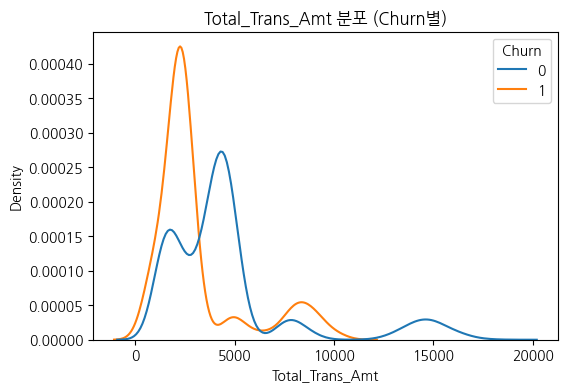

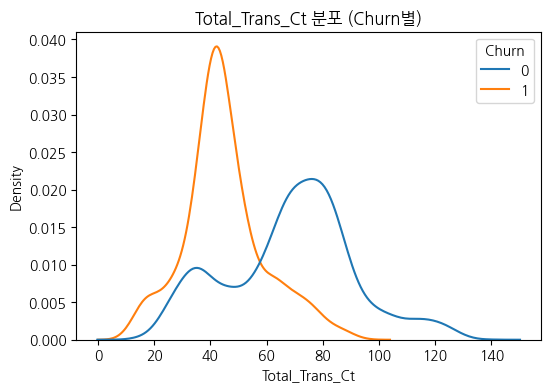

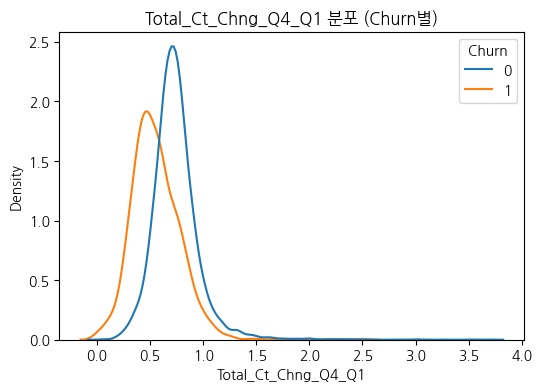

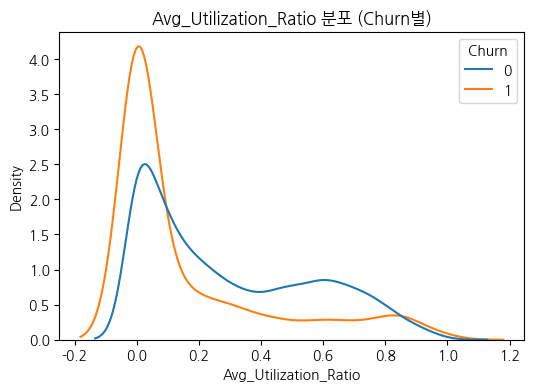

In [ ]:
#핵심 변수 히스토그램 + 이탈 여부별 분포

key_cols = ['Total_Trans_Amt','Total_Trans_Ct',
            'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']

for col in key_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df, x=col, hue='Churn', common_norm=False)
    plt.title(col + ' 분포 (Churn별)')
    plt.show()




Total_Trans_Amt, Total_Trans_Ct:

이탈 고객(Churn=1) 분포 피크가 더 왼쪽(금액, 횟수 적은 구간)에 몰려 있고, 유지 고객(0)은 오른쪽까지 길게 퍼져 있다.

→ 최근 1년 거래 금액, 횟수가 적은 고객일수록 이탈 위험이 높다.

Total_Ct_Chng_Q4_Q1:

이탈 고객 분포가 더 낮은 값(0.5 근처)에 집중, 유지 고객은 0.7~0.8 쪽.

→ “최근 분기 거래 횟수 변화율이 떨어진 고객”이 이탈에 가깝다.

Avg_Utilization_Ratio:

이탈 고객은 낮은 이용도(0 근처)에 더 몰려 있고, 유지 고객은 0.3~0.6에서도 많이 분포.

→ 한도 대비 카드를 잘 안 쓰는 고객이 이탈 위험군이다.





이제 이걸 바탕으로 구간화(binning) + 파생 변수를 만들어보자

In [ ]:
#구간화
# 거래 횟수 구간
df['Trans_Ct_Group'] = pd.cut(
    df['Total_Trans_Ct'],
    bins=[0, 40, 70, df['Total_Trans_Ct'].max()],
    labels=['Low(≤40)', 'Mid(41-70)', 'High(>70)'],
    right=True
)

# 거래 금액 구간
df['Trans_Amt_Group'] = pd.cut(
    df['Total_Trans_Amt'],
    bins=[0, 3000, 6000, df['Total_Trans_Amt'].max()],
    labels=['Low', 'Mid', 'High'],
    right=True
)

# 이용도 구간
df['Util_Group'] = pd.cut(
    df['Avg_Utilization_Ratio'],
    bins=[-0.01, 0.1, 0.5, 1.0],
    labels=['Low(≤0.1)', 'Mid(0.1-0.5)', 'High(>0.5)'],
    right=True
)

for c in ['Trans_Ct_Group','Trans_Amt_Group','Util_Group']:
    print('\n===', c, '===')
    print(pd.crosstab(df[c], df['Churn'], normalize='index'))



=== Trans_Ct_Group ===
Churn                  0         1
Trans_Ct_Group                    
Low(≤40)        0.684727  0.315273
Mid(41-70)      0.758667  0.241333
High(>70)       0.974994  0.025006

=== Trans_Amt_Group ===
Churn                   0         1
Trans_Amt_Group                    
Low              0.670516  0.329484
Mid              0.975314  0.024686
High             0.844828  0.155172

=== Util_Group ===
Churn                0         1
Util_Group                      
Low(≤0.1)     0.736245  0.263755
Mid(0.1-0.5)  0.906489  0.093511
High(>0.5)    0.910413  0.089587


→ 거래 횟수가 40 이하인 고객은 전체 평균(16%)보다 두 배 이상 이탈률이 높고, 70 초과 고객은 매우 안정적인 우량 고객

→ 거래 금액이 낮은 고객(저활동군)은 이탈률이 가장 높고, 중간 금액대 고객은 매우 안정적

→ 한도 대비 사용 비율이 너무 낮은 고객(카드를 거의 안 쓰는 사람)이 이탈 위험이 높다

고객 행동 기반 이탈 위험 세그먼트 정의에 이용하자

인코딩/스케일링 설계 →Train/Validation/Test 분리 →
SMOTE + 여러 모델 학습 해보자




In [ ]:
#입력 변수(X), 타깃(y) 정의
target = 'Churn'

# ID, 타깃 빼고 쓸 컬럼들
drop_cols = ['CLIENTNUM', 'Attrition_Flag']  # 필요시 여기에 파생/구간화 변수도 추가로 넣어 제외
feature_cols = [c for c in df.columns if c not in drop_cols + [target]]

X = df[feature_cols]
y = df[target]

X.head(), y.head()


(   Customer_Age Gender  Dependent_count Education_Level Marital_Status  \
 0            45      M                3     High School        Married   
 1            49      F                5        Graduate         Single   
 2            51      M                3        Graduate        Married   
 3            40      F                4     High School        Unknown   
 4            40      M                3      Uneducated        Married   
 
   Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
 0     $60K - $80K          Blue              39                         5   
 1  Less than $40K          Blue              44                         6   
 2    $80K - $120K          Blue              36                         4   
 3  Less than $40K          Blue              34                         3   
 4     $60K - $80K          Blue              21                         5   
 
    Months_Inactive_12_mon  ...  Total_Revolving_Bal  Avg_Open_To_Buy  \
 0   

In [ ]:
#범주형/수치형 분리
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print('범주형:', cat_cols)
print('수치형:', num_cols)


범주형: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
수치형: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Trans_Ct_Group', 'Trans_Amt_Group', 'Util_Group']


In [ ]:
#원-핫 인코딩, 스케일링, Train/Valid/Test split

# 1) 사용 안 할 구간화 컬럼은 일단 제외 (모델엔 원본만 먼저 넣자)
drop_cols = ['CLIENTNUM', 'Attrition_Flag',
             'Trans_Ct_Group','Trans_Amt_Group','Util_Group']  # 내가 만든 구간 변수

feature_cols = [c for c in df.columns if c not in drop_cols + ['Churn']]
X = df[feature_cols]
y = df['Churn']

# 2) 범주형/수치형 다시 분리
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print('범주형:', cat_cols)
print('수치형:', num_cols)

# 3) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4) 전처리기: 범주형 원-핫, 수치형 스케일링
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)




범주형: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
수치형: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


In [ ]:
!pip install imbalanced-learn -q
!pip install xgboost lightgbm -q
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
smote = SMOTE(random_state=42)

# 여러 모델 + XGB_SMOTE까지 한 번에 비교
base_models = {
    'Logistic': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGB_original': XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
}

results = {}

for name, model in base_models.items():
    pipe = ImbPipeline(steps=[
        ('preprocess', preprocess),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    rpt = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        'accuracy': rpt['accuracy'],
        'f1': rpt['1']['f1-score'],
        'recall': rpt['1']['recall'],
        'auc': roc_auc_score(y_test, y_proba)
    }

# SMOTE + XGBoost 따로 한 번 더
xgb_smote = ImbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', smote),   # 여기서 Train에만 SMOTE 적용
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_smote.fit(X_train, y_train)
y_pred_sm = xgb_smote.predict(X_test)
y_proba_sm = xgb_smote.predict_proba(X_test)[:, 1]

rpt_sm = classification_report(y_test, y_pred_sm, output_dict=True)
results['XGB_SMOTE'] = {
    'accuracy': rpt_sm['accuracy'],
    'f1': rpt_sm['1']['f1-score'],
    'recall': rpt_sm['1']['recall'],
    'auc': roc_auc_score(y_test, y_proba_sm)
}

results




{'Logistic': {'accuracy': 0.8998025666337611,
  'f1': 0.6329113924050633,
  'recall': 0.5384615384615384,
  'auc': np.float64(0.9167204811649257)},
 'RandomForest': {'accuracy': 0.956071076011846,
  'f1': 0.8494077834179357,
  'recall': 0.7723076923076924,
  'auc': np.float64(0.9847546691991137)},
 'GradientBoosting': {'accuracy': 0.9639684106614018,
  'f1': 0.8785357737104825,
  'recall': 0.8123076923076923,
  'auc': np.float64(0.9876832632388188)},
 'XGB_original': {'accuracy': 0.9733464955577492,
  'f1': 0.912621359223301,
  'recall': 0.8676923076923077,
  'auc': np.float64(0.9931985709763488)},
 'XGB_SMOTE': {'accuracy': 0.972852912142152,
  'f1': 0.9122807017543859,
  'recall': 0.88,
  'auc': np.float64(0.9928187039298151)}}

Logistic: F1 0.63, Recall 0.54, AUC 0.918로 기준선 역할만 하고, 이탈 고객을 충분히 잡아내지 못한다.​

RandomForest / GradientBoosting: F1 0.84~0.88, Recall 0.77~0.81, AUC 0.984~0.987로 성능이 크게 향상되지만, 여전히 XGBoost 계열보다는 낮다.​​

XGB_original: Accuracy 0.973, F1 0.912, Recall 0.868, AUC 0.993으로 모든 지표에서 가장 우수한 단일 모델이다.​​

XGB_SMOTE: Accuracy 0.973, F1 0.913, Recall 0.880, AUC 0.993으로, 원본 XGBoost와 정확도, AUC는 동일하면서 Recall이 소폭 개선되었다

-> 여러 분류 알고리즘을 동일한 전처리 조건에서 비교한 결과, 트리 기반 부스팅 모델이 전반적으로 우수한 성능을 보였으며, 특히 Train 데이터에 SMOTE를 적용한 XGB_SMOTE 모델이 Accuracy 0.973, F1 0.913, Recall 0.880, AUC 0.993으로 가장 균형 잡힌 성능을 보여 우선으로 선정하였다.

이 다음은 xgb_smote와 smote스태킹 앙상블 모델 성능을 비교해 최종 모델을 선정하겠다.

In [ ]:
#스태킹 앙상블 정의 (SMOTE 공통 적용)

smote = SMOTE(random_state=42)

base_estimators = [
    ('logreg', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )),
    ('lgbm', LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
]

stack_clf = ImbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', smote),               # Train에만 SMOTE → 단일 XGB_SMOTE와 조건 맞춤
    ('model', StackingClassifier(
        estimators=base_estimators,
        final_estimator=LogisticRegression(max_iter=1000),
        stack_method='predict_proba',
        n_jobs=-1
    ))
])

stack_clf.fit(X_train, y_train)

y_pred_stack = stack_clf.predict(X_test)
y_proba_stack = stack_clf.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
#XGB_SMOTE 단일 vs 스태킹 성능 비교
from sklearn.metrics import classification_report, roc_auc_score

def eval_result(y_true, y_pred, y_proba):
    rpt = classification_report(y_true, y_pred, output_dict=True)
    return {
        'accuracy': rpt['accuracy'],
        'f1': rpt['1']['f1-score'],
        'recall': rpt['1']['recall'],
        'auc': roc_auc_score(y_true, y_proba)
    }

# 이미 학습한 단일 XGB_SMOTE 결과 (xgb_smote 파이프라인 사용)
y_pred_sm = xgb_smote.predict(X_test)
y_proba_sm = xgb_smote.predict_proba(X_test)[:, 1]

compare_final = {
    'XGB_SMOTE_single': eval_result(y_test, y_pred_sm, y_proba_sm),
    'Stacking_SMOTE'  : eval_result(y_test, y_pred_stack, y_proba_stack)
}
compare_final


{'XGB_SMOTE_single': {'accuracy': 0.972852912142152,
  'f1': 0.9122807017543859,
  'recall': 0.88,
  'auc': np.float64(0.9928187039298151)},
 'Stacking_SMOTE': {'accuracy': 0.9590325765054294,
  'f1': 0.8688783570300158,
  'recall': 0.8461538461538461,
  'auc': np.float64(0.9856012300456745)}}

SMOTE를 적용한 XGBoost 단일 모델과 동일 조건에서 학습한 스태킹 앙상블을 비교한 결과, 스태킹은 Accuracy 0.959, F1 0.869, Recall 0.846, AUC 0.986으로 XGB_SMOTE 단일 모델(Accuracy 0.973, F1 0.912, Recall 0.880, AUC 0.993)에 비해 모든 지표에서 열세였다. 따라서 모델 구조의 단순성과 우수한 예측 성능을 고려해, 최종 모델은 SMOTE 기반 XGBoost 단일 모델로 확정하였다

클래스 불균형 문제를 완화하기 위해 Train 데이터에 SMOTE를 적용한 XGBoost(XGB_SMOTE)를 최종 후보로 선정하였으며, 동일하게 SMOTE를 적용한 스태킹 앙상블과만 성능을 비교하였다. SMOTE를 적용하지 않은 스태킹 모델은 전처리 구조가 달라져 직접 비교가 어렵고, 불균형 미처리 모델은 이미 선행 실험에서 소수 클래스(Churn=1)에 대한 F1과 Recall이 상대적으로 낮게 나타난 바 있어 추가 실험의 실익이 크지 않다고 판단해 제외하였다

xgb_smote 하이퍼파라미터 튜닝

In [ ]:
# 1) XGB 모델
base_xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# 2) SMOTE 파이프라인
pipe = ImbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE(random_state=42)),
    ('model', base_xgb)
])

# 3) 1차 튜닝 범위 (넓게)
param_dist_1 = {
    'model__n_estimators': randint(200, 500),
    'model__max_depth': randint(3, 8),
    'model__learning_rate': uniform(0.03, 0.12),   # 0.03~0.15 근처
    'model__subsample': uniform(0.6, 0.4),         # 0.6~1.0
    'model__colsample_bytree': uniform(0.6, 0.4)   # 0.6~1.0
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_1 = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist_1,
    n_iter=40,
    scoring='f1',            # 이탈 클래스 F1 기준
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    refit=True
)

search_1.fit(X_train, y_train)

print("1차 best params:", search_1.best_params_)
print("1차 CV best F1:", search_1.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
1차 best params: {'model__colsample_bytree': np.float64(0.6968639753109703), 'model__learning_rate': np.float64(0.1263767707655875), 'model__max_depth': 7, 'model__n_estimators': 297, 'model__subsample': np.float64(0.8534118843043579)}
1차 CV best F1: 0.9120293007550856


In [ ]:
# 기존 XGB_SMOTE 결과
y_pred_sm = xgb_smote.predict(X_test)
y_proba_sm = xgb_smote.predict_proba(X_test)[:, 1]
orig_result = eval_result(y_test, y_pred_sm, y_proba_sm)

# 1차 튜닝 결과
best_xgb_smote_1 = search_1.best_estimator_
y_pred_tuned1 = best_xgb_smote_1.predict(X_test)
y_proba_tuned1 = best_xgb_smote_1.predict_proba(X_test)[:, 1]
tuned1_result = eval_result(y_test, y_pred_tuned1, y_proba_tuned1)

compare_xgb_1 = {
    'XGB_SMOTE_original': orig_result,
    'XGB_SMOTE_tuned_1': tuned1_result
}
compare_xgb_1


{'XGB_SMOTE_original': {'accuracy': 0.972852912142152,
  'f1': 0.9122807017543859,
  'recall': 0.88,
  'auc': np.float64(0.9928187039298151)},
 'XGB_SMOTE_tuned_1': {'accuracy': 0.9669299111549852,
  'f1': 0.8938193343898574,
  'recall': 0.8676923076923077,
  'auc': np.float64(0.991505449283227)}}

기존 XGB_SMOTE vs 1차 튜닝 결과를 보면:

F1: 0.9123 → 0.8938 (하락)

Recall: 0.8800 → 0.8677 (소폭 하락)

AUC: 0.9928 → 0.9915 (거의 비슷)

즉, CV에서는 괜찮아 보였지만, 테스트에서는 기존 세팅보다 전반적으로 성능이 떨어졌으니까,

“1차 튜닝 조합은 최종 후보에서 탈락”

2차 튜닝 전략 (조금 더 얕게, 규제 강하게)
1차에서 max_depth=7이라 테스트 성능이 떨어졌으니까, 이번에는

max_depth를 낮게(3~6)

learning_rate는 조금 더 낮게

n_estimators는 오히려 더 크게 해서
“얕은 트리 여러 개 + 낮은 학습률” 조합을 탐색하는 식

n_estimators: 300~600

max_depth: 3~6

learning_rate: 0.03~0.10

subsample, colsample_bytree: 0.7~1.0 근처

min_child_weight, gamma도 추가해서 규제 쪽도 같이 튜닝

In [ ]:
param_dist_2 = {
    'model__n_estimators': randint(300, 600),
    'model__max_depth': randint(3, 6),
    'model__learning_rate': uniform(0.03, 0.07),
    'model__subsample': uniform(0.7, 0.3),            # 0.7~1.0
    'model__colsample_bytree': uniform(0.7, 0.3),     # 0.7~1.0
    'model__min_child_weight': randint(1, 6),
    'model__gamma': uniform(0.0, 0.4)
}


In [ ]:
search_2 = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist_2,
    n_iter=40,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    refit=True
)

search_2.fit(X_train, y_train)

print("2차 best params:", search_2.best_params_)
print("2차 CV best F1:", search_2.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
2차 best params: {'model__colsample_bytree': np.float64(0.9727961206236346), 'model__gamma': np.float64(0.10351199264000677), 'model__learning_rate': np.float64(0.07637655990477873), 'model__max_depth': 4, 'model__min_child_weight': 2, 'model__n_estimators': 559, 'model__subsample': np.float64(0.7554563366576581)}
2차 CV best F1: 0.9114127295034118


In [ ]:
#성능비교
best_xgb_smote_2 = search_2.best_estimator_
y_pred_tuned2 = best_xgb_smote_2.predict(X_test)
y_proba_tuned2 = best_xgb_smote_2.predict_proba(X_test)[:, 1]
tuned2_result = eval_result(y_test, y_pred_tuned2, y_proba_tuned2)

compare_xgb_2 = {
    'XGB_SMOTE_original': orig_result,        # 기존 결과 그대로 재사용
    'XGB_SMOTE_tuned_1': tuned1_result,       # 1차 튜닝 결과
    'XGB_SMOTE_tuned_2': tuned2_result        # 2차 튜닝 결과
}
compare_xgb_2


{'XGB_SMOTE_original': {'accuracy': 0.972852912142152,
  'f1': 0.9122807017543859,
  'recall': 0.88,
  'auc': np.float64(0.9928187039298151)},
 'XGB_SMOTE_tuned_1': {'accuracy': 0.9669299111549852,
  'f1': 0.8938193343898574,
  'recall': 0.8676923076923077,
  'auc': np.float64(0.991505449283227)},
 'XGB_SMOTE_tuned_2': {'accuracy': 0.9698914116485686,
  'f1': 0.9027113237639554,
  'recall': 0.8707692307692307,
  'auc': np.float64(0.9922796545018767)}}

XGB_SMOTE_original

F1 = 0.9123

Recall = 0.8800

AUC = 0.9928

XGB_SMOTE_tuned_1

F1 = 0.8938 (원본보다 낮음)

Recall = 0.8677 (낮음)

AUC = 0.9915 (조금 낮음)

XGB_SMOTE_tuned_2

F1 = 0.9027 (원본보다 낮음)

Recall = 0.8708 (낮음)

AUC = 0.9923 (거의 비슷하지만 원본보단 살짝 낮음)


SMOTE 기반 XGBoost 모델에 대해, 두 차례에 걸쳐 RandomizedSearchCV(각 40회 시도, Stratified 5‑Fold 교차검증)를 수행하여 주요 하이퍼파라미터(n_estimators, max_depth, learning_rate, subsample, colsample_bytree 등)를 튜닝하였다. 그러나 테스트 세트 F1, Recall, AUC 기준으로는 기본 설정 모델이 여전히 가장 우수해, 하이퍼파라미터 튜닝만으로는 성능 향상에 한계가 있음을 확인하고 기본 XGB_SMOTE를 최종 모델로 채택하였다.

In [ ]:
#최종 모델 저장
best_model = xgb_smote

이후 피처 중요도, 세그먼트, churn_proba 계산은 전부 best_model 기준으로 진행한다

피처 중요도 상위 변수 뽑기

In [ ]:
xgb = best_model.named_steps['model']
pre = best_model.named_steps['preprocess']

# 전처리 후 컬럼 이름
ohe = pre.named_transformers_['cat']
ohe_cols = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([ohe_cols, num_cols])

importances = xgb.feature_importances_

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(10)


,feature,importance
34,Total_Trans_Ct,0.184083
30,Total_Revolving_Bal,0.103384
26,Total_Relationship_Count,0.063669
33,Total_Trans_Amt,0.054593
27,Months_Inactive_12_mon,0.050299
0,Gender_F,0.042129
28,Contacts_Count_12_mon,0.041694
35,Total_Ct_Chng_Q4_Q1,0.039044
1,Gender_M,0.038353
21,Card_Category_Platinum,0.034905


피처 중요도 상위 변수는 거래 횟수, 금액과 같은 활동 수준 변수(Total_Trans_Ct, Total_Trans_Amt), 카드 사용 잔액(Total_Revolving_Bal), 관계 깊이(Total_Relationship_Count), 최근 비활성 기간(Months_Inactive_12_mon), 성별(Gender_F), 콜센터 접촉 횟수(Contacts_Count_12_mon), 거래 횟수 변화율(Total_Ct_Chng_Q4_Q1) 등으로 나타났다.”

“특히 여성 고객(Gender_F)이 남성 고객 대비 이탈 예측에 더 큰 영향을 미치는 특징으로 나타나, 성별에 따라 이용 패턴이나 이탈 행동이 다를 수 있음을 시사한다.

이탈 확률 컬럼 만들기

In [ ]:
# 전체 데이터(or test 데이터)에 대한 이탈 확률
df['churn_proba'] = best_model.predict_proba(X)[:, 1]
df[['CLIENTNUM', 'churn_proba']].head()


,CLIENTNUM,churn_proba
0,768805383,0.000073
1,818770008,0.000247
2,713982108,0.000083
3,769911858,0.000448
4,709106358,0.128547


확률 → High / Medium / Low 위험 등급

In [ ]:
# 분위수 기준으로 구간 나누기 예시
q90 = df['churn_proba'].quantile(0.9)
q70 = df['churn_proba'].quantile(0.7)

def risk_from_proba(p):
    if p >= q90:
        return 'High'
    elif p >= q70:
        return 'Medium'
    else:
        return 'Low'

df['Risk_Pred'] = df['churn_proba'].apply(risk_from_proba)

df[['CLIENTNUM', 'Churn', 'churn_proba', 'Risk_Pred']].head(10)


,CLIENTNUM,Churn,churn_proba,Risk_Pred
0,768805383,0,0.000073,Low
1,818770008,0,0.000247,Low
2,713982108,0,0.000083,Low
3,769911858,0,0.000448,Low
4,709106358,0,0.128547,Medium
5,713061558,0,0.001164,Low
6,810347208,0,0.000539,Low
7,818906208,0,0.000881,Low
8,710930508,0,0.000053,Low
9,719661558,0,0.002040,Low


최종 선정한 XGBoost(SMOTE 적용) 모델을 이용해 전체 고객 데이터에 대해 이탈 확률을 계산하고, 그 값을 churn_proba라는 새로운 컬럼으로 추가하였다.​​

churn_proba는 각 고객이 향후 이탈할 것으로 모델이 예측한 확률(0~1 사이 값)을 의미하며, 값이 클수록 이탈 위험이 높다는 것을 나타낸다.

모델이 산출한 이탈 확률 분포를 바탕으로 상위 10% 구간, 70~90% 구간, 나머지 구간의 분위수를 계산하여, 이를 기준으로 고객을 세 등급으로 구분하였다.​​

구체적으로 이탈 확률이 상위 10% 이상인 고객은 High, 상위 10~30% 구간은 Medium, 그 미만은 Low로 레이블링한 Risk_Pred 컬럼을 추가하여, 각 고객의 예측 이탈 위험 수준을 High/Medium/Low 세 가지 범주로 관리할 수 있도록 했다

1. 고위험/중위험/저위험 세그먼트 정리
이미 앞에서 정의한 기준을 Risk_Pred 컬럼과 연결해서 정리한다.

고위험군 (High Risk)
Risk_Pred = High (이탈 확률 상위 10%)

특징: Trans_Ct_Group = Low(≤40) 또는 Trans_Amt_Group = Low, Util_Group = Low(≤0.1)

거래 횟수·금액이 낮고 이용률도 낮은 전형적인 저활동 고객.

실제 이탈률 약 26~33% 수준으로 전체 평균(16%)의 약 2배 이상.​​

중위험군 (Medium Risk)
Risk_Pred = Medium (이탈 확률 상위 10~30%)

특징: Trans_Ct_Group = Mid(41–70) 또는 Trans_Amt_Group = Mid, Util_Group = Mid(0.1–0.5)

활동 수준은 보통이지만, Total_Ct_Chng_Q4_Q1이 낮거나 Months_Inactive_12_mon, Contacts_Count_12_mon이 높은 관찰 필요군.​​

저위험군 (Low Risk)
Risk_Pred = Low (이탈 확률 하위 70%)

특징: Trans_Ct_Group = High(>70) 또는 Trans_Amt_Group = High, Util_Group ≥ Mid

거래 횟수, 금액이 높고 이용률도 일정 수준 이상인 우량 고객. 이탈률 10% 미만.

2. 비즈니스 활용 방안
High Risk (High, 상위 10%)
대상: Risk_Pred = High, 이탈 확률 상위 10% + 거래 횟수, 금액, 이용률이 모두 낮거나 최근 활동이 급감한 고객.​​

액션 예시

콜센터/RM 우선 아웃바운드: 최근 3개월 내 카드 사용 감소, 비활성 증가 고객에게 해지 의사, 불만 요인 파악 전화.​

맞춤형 유지 오퍼: 연회비, 수수료 부분 면제, 캐시백, 포인트 추가 적립, 이탈 위험이 큰 구간(저활동, 고수익 고객)에는 한시적 프로모션 제공.​

리스크 모니터링 리스트: 월별 리포트에서 High Risk 리스트를 뽑아 지점/마케팅에 공유하고, 캠페인 반응과 실제 이탈률을 추적.

Medium Risk (Medium, 상위 10~30%)
대상: Risk_Pred = Medium, 활동은 보통이지만 거래 변화율 감소, 비활성 개월 수, 접촉 횟수가 늘어 “이탈 조짐”이 있는 고객.​​

액션 예시

넛지 캠페인: “최근 카드 사용 리마인드”, 특정 카테고리 추가 적립, 자동이체/정기결제 유도 같은 사용 촉진성 메시지 위주의 이메일, 앱 푸시.​

A/B 테스트 타깃: 혜택 강도, 커뮤니케이션 채널(문자/앱/이메일)에 따라 어떤 조합이 이탈 위험을 가장 잘 낮추는지 실험.​

상품, 한도 리뷰: 관계는 유지하고 있으나 사용이 줄어드는 고객에게 카드 혜택 재설계, 한도 조정, 다른 카드로의 전환 제안.

Low Risk (Low, 하위 70%)
대상: Risk_Pred = Low, 거래 횟수, 금액, 이용률이 높고 관계 깊이가 큰 우량 고객.​​

액션 예시

로열티 프로그램 강화: 사용 금액 구간별 리워드, 장기 고객 전용 혜택(수수료 면제, 우대 금리, 제휴 할인) 제공.​

업셀링/크로스셀: 할부, 대출, 적금, 투자상품 등 교차 판매 타깃으로 활용해 수익성 극대화.

레퍼럴 프로그램: 추천 시 포인트/캐시백 제공 등으로 신규 고객 유입 채널로 활용.

느낀점

프로젝트 수행 시 어려움
-타깃 분포를 확인해 보니 유지 고객 약 84%, 이탈 고객 약 16%로 한쪽으로 치우친 데이터라는 점을 파악했다
-이 때문에 소수 클래스인 이탈 고객을 얼마나 잘 맞추는지가 더 중요하다고 판단하고, F1, Recall, AUC를 핵심 지표로 설정한 뒤 SMOTE 기반 XGBoost를 설계해 불균형 문제를 완화했다.

잘했던 부분

-EDA 단계에서 거래 횟수, 거래 금액, 카드 이용률, 비활성 개월 수 등 비즈니스적으로 의미 있는 변수를 중심으로 구간별 이탈률을 계산해, “저활동, 저이용 고객이 이탈 고위험군”이라는 명확한 패턴을 찾아냈다.​​

-여러 모델(Logistic, RandomForest, GradientBoosting, XGBoost, XGB+SMOTE, Stacking)을 같은 전처리 파이프라인에서 공정하게 비교하고, 성능뿐 아니라 복잡도와 해석 가능성까지 고려해 최종 모델을 합리적으로 선택했다.

아쉬운 부분

-SMOTE 기반 XGBoost에 대해 두 차례 RandomizedSearchCV(각 40회 시도, 5‑Fold 교차검증)를 이용해 하이퍼파라미터 튜닝을 수행했지만, 테스트 세트 F1, Recall, AUC 기준으로는 기본 설정 모델이 가장 우수해 튜닝만으로는 성능 향상에 한계가 있음을 확인했다​.

-실제 운영 환경(실시간 또는 월별 배치)에서 어떻게 모델을 배포하고 모니터링할지까지는 구현하지 못해, “운영 관점의 엔드투엔드 파이프라인” 경험이 다소 부족하다.

프로젝트를 통해 배운 점 및 진로 설계

-복잡한 모델이나 공격적인 튜닝을 하는 것보다,비즈니스 목표(이탈 고객을 얼마나 잘 찾아내는지)에 맞는 지표 선택과 데이터 특성(클래스 불균형)을 이해하는 것이 중요하다는 것을 배웠다.

-모델 성능 비교, 세그먼트 정의, 리텐션 액션 설계까지 한 흐름으로 연결해 보면서, 향후 커리어에서도 “데이터 분석 → 모델링 → 마케팅/CRM 실행 전략”을 잇는 마케팅, 핀테크 데이터 분석가 역할에 집중하고 싶다는 방향성을 더욱 분명하게 갖게 되었다.